Now we'll explore another optimizer RMSProp. This differs in that it adjusts the actual learning rate while it learns.

In [1]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Again, this is our objective function -- we'll visualize it again to jog our memory!

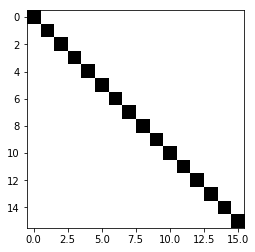

In [2]:
size = 16
batch_size = 32
objective = nd.ones(size).diag()
plt.imshow(objective.asnumpy(), cmap='binary')

Now - a set of random inputs and outputs, including a data loader to dispense mini batches. We'll even use way less data with these more advanced learning optimizers -- they are that powerful!

In [3]:
inputs = [nd.random.uniform(shape=(size, size)) for i in range(10*1024)]
outputs = [input * objective for input in inputs]
dataset = mx.gluon.data.dataset.ArrayDataset(inputs, outputs)
data_loader = mx.gluon.data.DataLoader(dataset, batch_size=batch_size)

OK -- now we'll set up to learn, starting with a random matrix. 

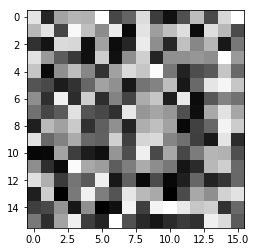

In [4]:
#everything will be run on the CPU context, these are really simple models
ctx = mx.cpu()

params = gluon.parameter.ParameterDict('_')
learned_diagonal = params.get('learned_diagonal', grad_req='write', shape=(size, size))
params.initialize(ctx=ctx)
plt.imshow(learned_diagonal.data().asnumpy(), cmap='binary')

Our simple network -- again same as the last video, we'll only be changing the training algorithm.

In [5]:
def net(input):
    return input * learned_diagonal.data()

def learn(net, optimizer):
    params.initialize(ctx=ctx, force_reinit=True)
    epochs = 10
    #initial value, so we can see where we started
    learning_steps = []
    learning_steps.append(learned_diagonal.data().asnumpy())
    #simple loss function
    square_loss = gluon.loss.L2Loss()
    losses = []
    for e in range(epochs):
        for input_batch, output_batch in data_loader:
            with autograd.record():
                predicted = net(input_batch)
                loss = square_loss(predicted, output_batch)
                loss.backward()
            optimizer.step(input_batch.shape[0])
        learning_steps.append(learned_diagonal.data().asnumpy())

        print("Loss: {0}".format(nd.sum(loss).asscalar()), flush=True)
        losses.append(nd.sum(loss).asscalar())
    return learning_steps, losses
    

And here is a function to make an animated bitmap of the learning. At each step, we are simply showing an image, and then joining it together with the `FuncAnimation` class.

In [6]:
def animate(frames):
    fig, ax = plt.subplots(figsize=(4, 4))

    def update(i):
        ax.imshow(frames[i], cmap='binary')
        ax.set_axis_off()

    anim = animation.FuncAnimation(fig, update, frames=len(frames), interval=200)
    plt.close()
    return HTML(anim.to_jshtml())

In [7]:
optimizer = gluon.Trainer(params, 'rmsprop')
learning_steps, losses = learn(net, optimizer)
animate(learning_steps)

Loss: 0.15765221416950226
Loss: 0.04857292398810387
Loss: 0.003431460587307811
Loss: 2.4934806788223796e-06
Loss: 5.548010939548931e-10
Loss: 9.360708822653274e-13
Loss: 8.000876979170901e-13
Loss: 7.776969172812453e-13
Loss: 7.63620286794997e-13
Loss: 7.580392476919107e-13


Wow! Changing just the learning optimizer and we nearly instantly learn the function.

Now we can take a look at the loss. Basically, this converges to effectively zero loss right away.

In [8]:
import numpy as np
def plot_loss(total_loss):
    x_axis = np.linspace(0, len(total_loss), len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()


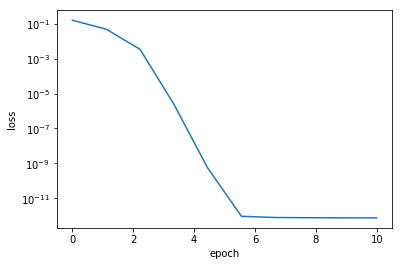

In [9]:
plot_loss(losses)

Interesting! Effectively an 'instant' learning. One more algorithm to try -- ADAM.

In [10]:
optimizer = gluon.Trainer(params, 'adam')
learning_steps, losses = learn(net, optimizer)
animate(learning_steps)

Loss: 0.1666698306798935
Loss: 0.07298122346401215
Loss: 0.026913592591881752
Loss: 0.007997341454029083
Loss: 0.0018270820146426558
Loss: 0.00030608687666244805
Loss: 3.580633347155526e-05
Loss: 2.7687633519235533e-06
Loss: 1.3300744683419907e-07
Loss: 3.618957578055415e-09


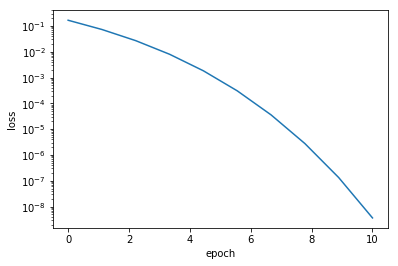

In [11]:
plot_loss(losses)

Again, a very good solution -- and just two epochs before we recognize our diagonal. Look at the loss however, it doesn't just flatten out. Adam has a bit more -- liveliness -- which can help it to not get stuck in 'valleys' in your data. Now our simple problem here -- the diagonal - is a solid ridge, there aren't any other ridges or valleys in our data to get stuck.

So -- in addition to parameters, you can also change the actual learning algorithm as a *hyperparameter*. For different data, different learning algorithms can lead to better results!